# Python notebook for post-processing apical responses.
# Peak counting in the results data.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
Execute the code sequentially, one block at a time, using &lt;shift-return&gt;.

In [1]:
import csv
import glob
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from scipy.io.wavfile import write
from scipy import signal


#### Select a results directory and set analysis frame range.


In [2]:
%matplotlib widget

# global variables
results_sel = ""  # the selected results directory
stim_start = 100  # analysis start frame
stim_done = 250   # analysis end frame

s = {'description_width':'200px'} # a default widget style

# create results directory widget
result_dirs = sorted([f.split('/')[-2] for f in glob.glob("../results/*/", recursive=False)], key=str.casefold)
results_widget = widgets.Select(options=result_dirs, description='Results dir', 
                            disabled=False, layout=widgets.Layout(width='400px'))
# create numeric input widgets
stim_start_widget = widgets.BoundedIntText(value=stim_start, min=0, max=1000, step=1,
                    description='Stimulation start frame', disabled=False, layout={'width':'270px'}, style=s)
stim_done_widget = widgets.BoundedIntText(value=stim_done, min=0, max=1000, step=1,
                    description='Stimulation done frame', disabled=False, layout={'width':'270px'}, style=s)

# create status widget
status_widget = widgets.HTML(value=' ', description=' ')

# display and respond to the widgets
def f(w1, w2, w3, w4):
  global results_sel
  global stim_start, stim_done
  results_sel = results_widget.value
  stim_start = stim_start_widget.value
  stim_done = stim_done_widget.value

  if not results_sel:
    status_widget.value = "No result directory selected."
  else:
    status_widget.value = "Selection OK."
display(widgets.interactive(f, w1=results_widget, w2=status_widget,
                           w3=stim_start_widget, w4=stim_done_widget))

interactive(children=(Select(description='Results dir', layout=Layout(width='400px'), options=('20200713-20182…

#### Peak counting over all regions.

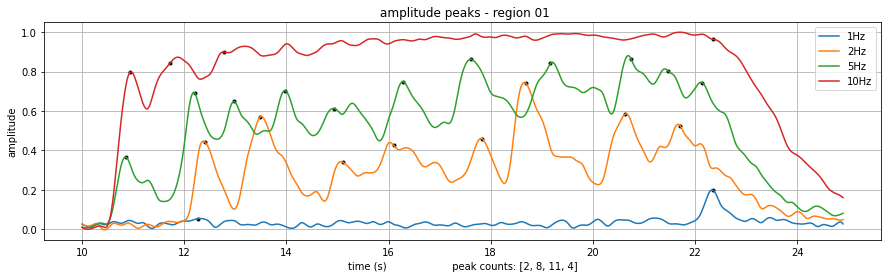

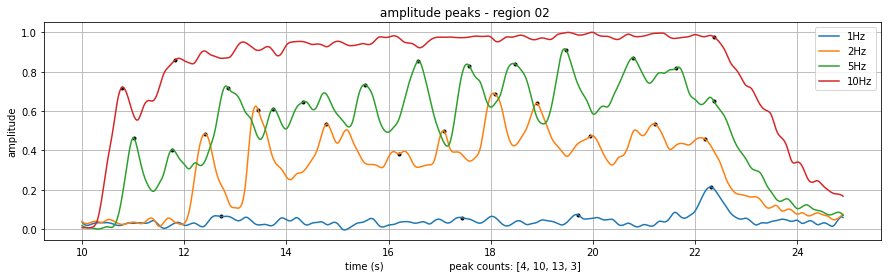

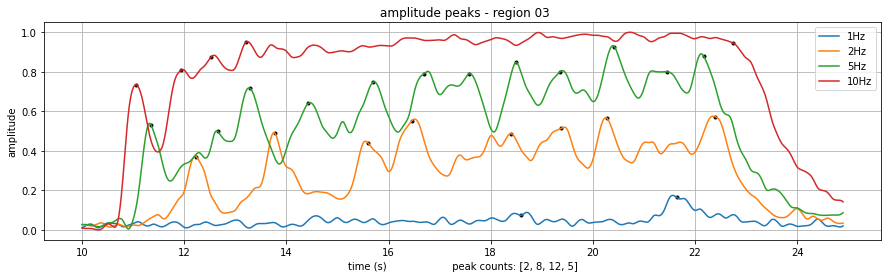

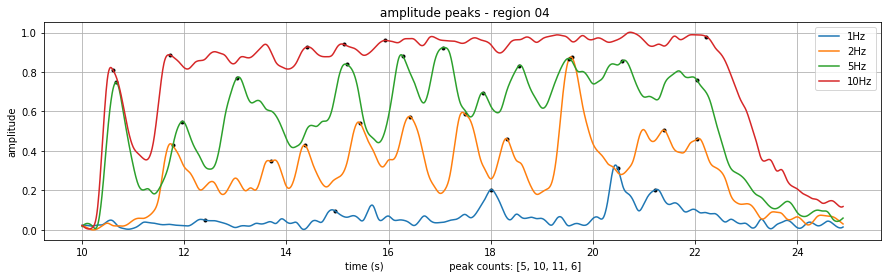

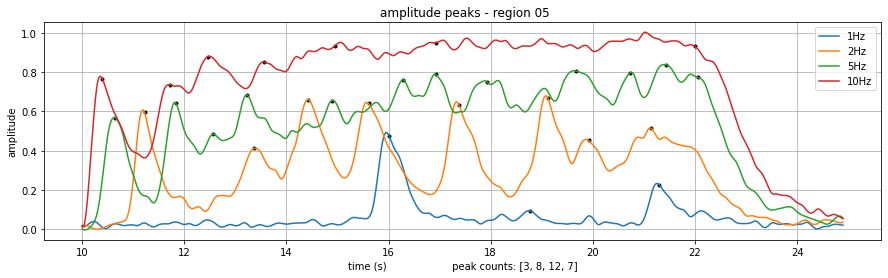

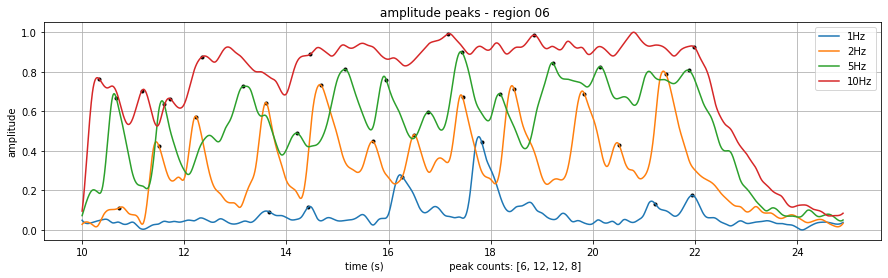

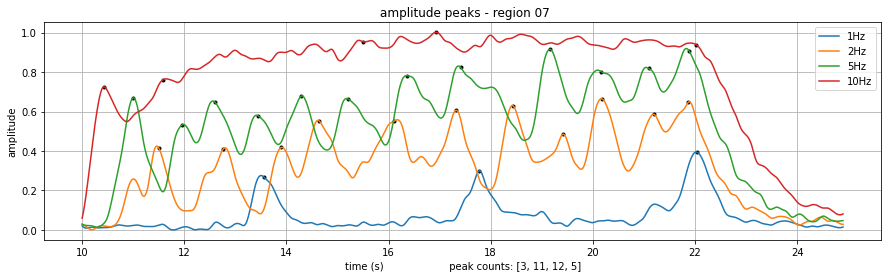

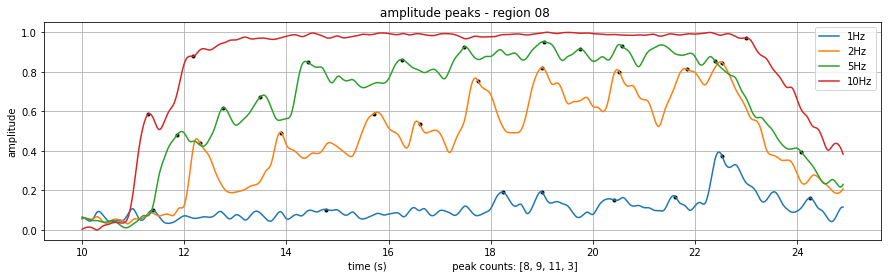

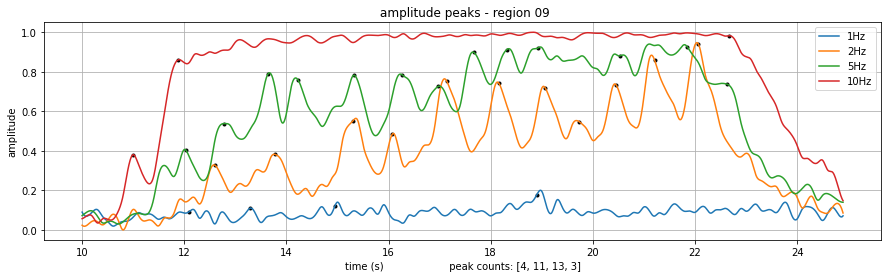

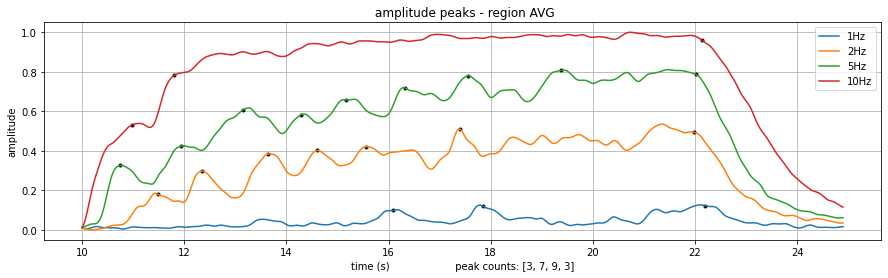

In [75]:
%matplotlib inline

# get the regions and data labels in the selected results directory 
region_files = os.listdir("../results/" + results_widget.value)
region_files = sorted([f for f in region_files if 'apical_region' in f and '.csv' in f])
with open("../results/" + results_widget.value + "/labels.txt") as f:
  data_labels = f.readlines()
data_labels = [x.strip() for x in data_labels] 

p = 2000                   # desired length of resampled data
pkall = []                 # the number of peaks across all regions
for r in region_files:     # for each region
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [15,4])
  ax.grid(b=True)

  region = r.split('_')[-1].split('-')[0]  # get the region number
  A0 = np.transpose(np.genfromtxt("../results/" + results_sel + "/" + r, delimiter=','))
  A = A0[:,stim_start:stim_done]  # trim the data to the stimulated time
  tmin = np.min(A[0])      # start time
  tmax = np.max(A[0])      # finish time
  trng = tmax-tmin         # time range
  tstp = A0[0,1]-A0[0,0]   # time step
  dmin = np.min(A[1:])     # minimum data value (over all traces)
  dmax = np.max(A[1:])     # maximum data value
  drng = dmax-dmin         # data range
  X0 = A[0]                # the time axis
  Y0 = (A[1:]-dmin) / drng # data axis, normalized to range(0, 1.0)

  sr = p / trng   # the sample rate
  pk = []
  for idx,y in enumerate(Y0): # for each trace
    f = interp1d(X0, y, kind='cubic')                     # define the resampling function
    X = np.linspace(tmin, tmax, p+1, endpoint=True)       # define the new time steps
    Y = f(X)                                              # resample the original signal

    # apply high-pass filter to eliminate the stimulation "bump" in the data
    sos = signal.butter(3, 0.1, btype='highpass', fs=sr, output='sos')
    Yf = signal.sosfiltfilt(sos, Y) # zero phase shift filter

    # apply low-pass filter to smooth out higher frequencies in the data
    sos = signal.butter(7, 2.0, btype='lowpass', fs=sr, output='sos')
    Yf = signal.sosfiltfilt(sos, Yf) # zero phase shift filter

    pks,_ = signal.find_peaks(Yf,prominence=0.04)         # find peaks
    pk.append(len(pks))
    ax.plot(X[pks],Y[pks],'k.')                           # plot the peak locations
    ax.plot(X,Y,label=str(data_labels[idx]))              # plot the resampled data
    
  pkall.append(pk) # append the number of peaks for this region to the overall list
  ax.legend()
  ax.set_title(" amplitude peaks - region " + region)
  ax.set(xlabel="time (s)                     peak counts: " + str(pk))
  ax.set(ylabel="amplitude")

  # save figure to pdf
  fig.savefig("../results/" + results_widget.value +'/' + "peaks" + "_region_" + region + ".pdf")
  plt.show()
  plt.close() # frees up memory

# save peak counts to CSV file
with open ("../results/" + results_widget.value +'/' + "peaks_region_ALL.csv", 'w') as file:
  writer = csv.writer(file)
  for row in pkall:
    writer.writerow(row)

